# Image Features and Alignment

## Import the Libraries

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import Image

%matplotlib inline

## Align Image to a Template

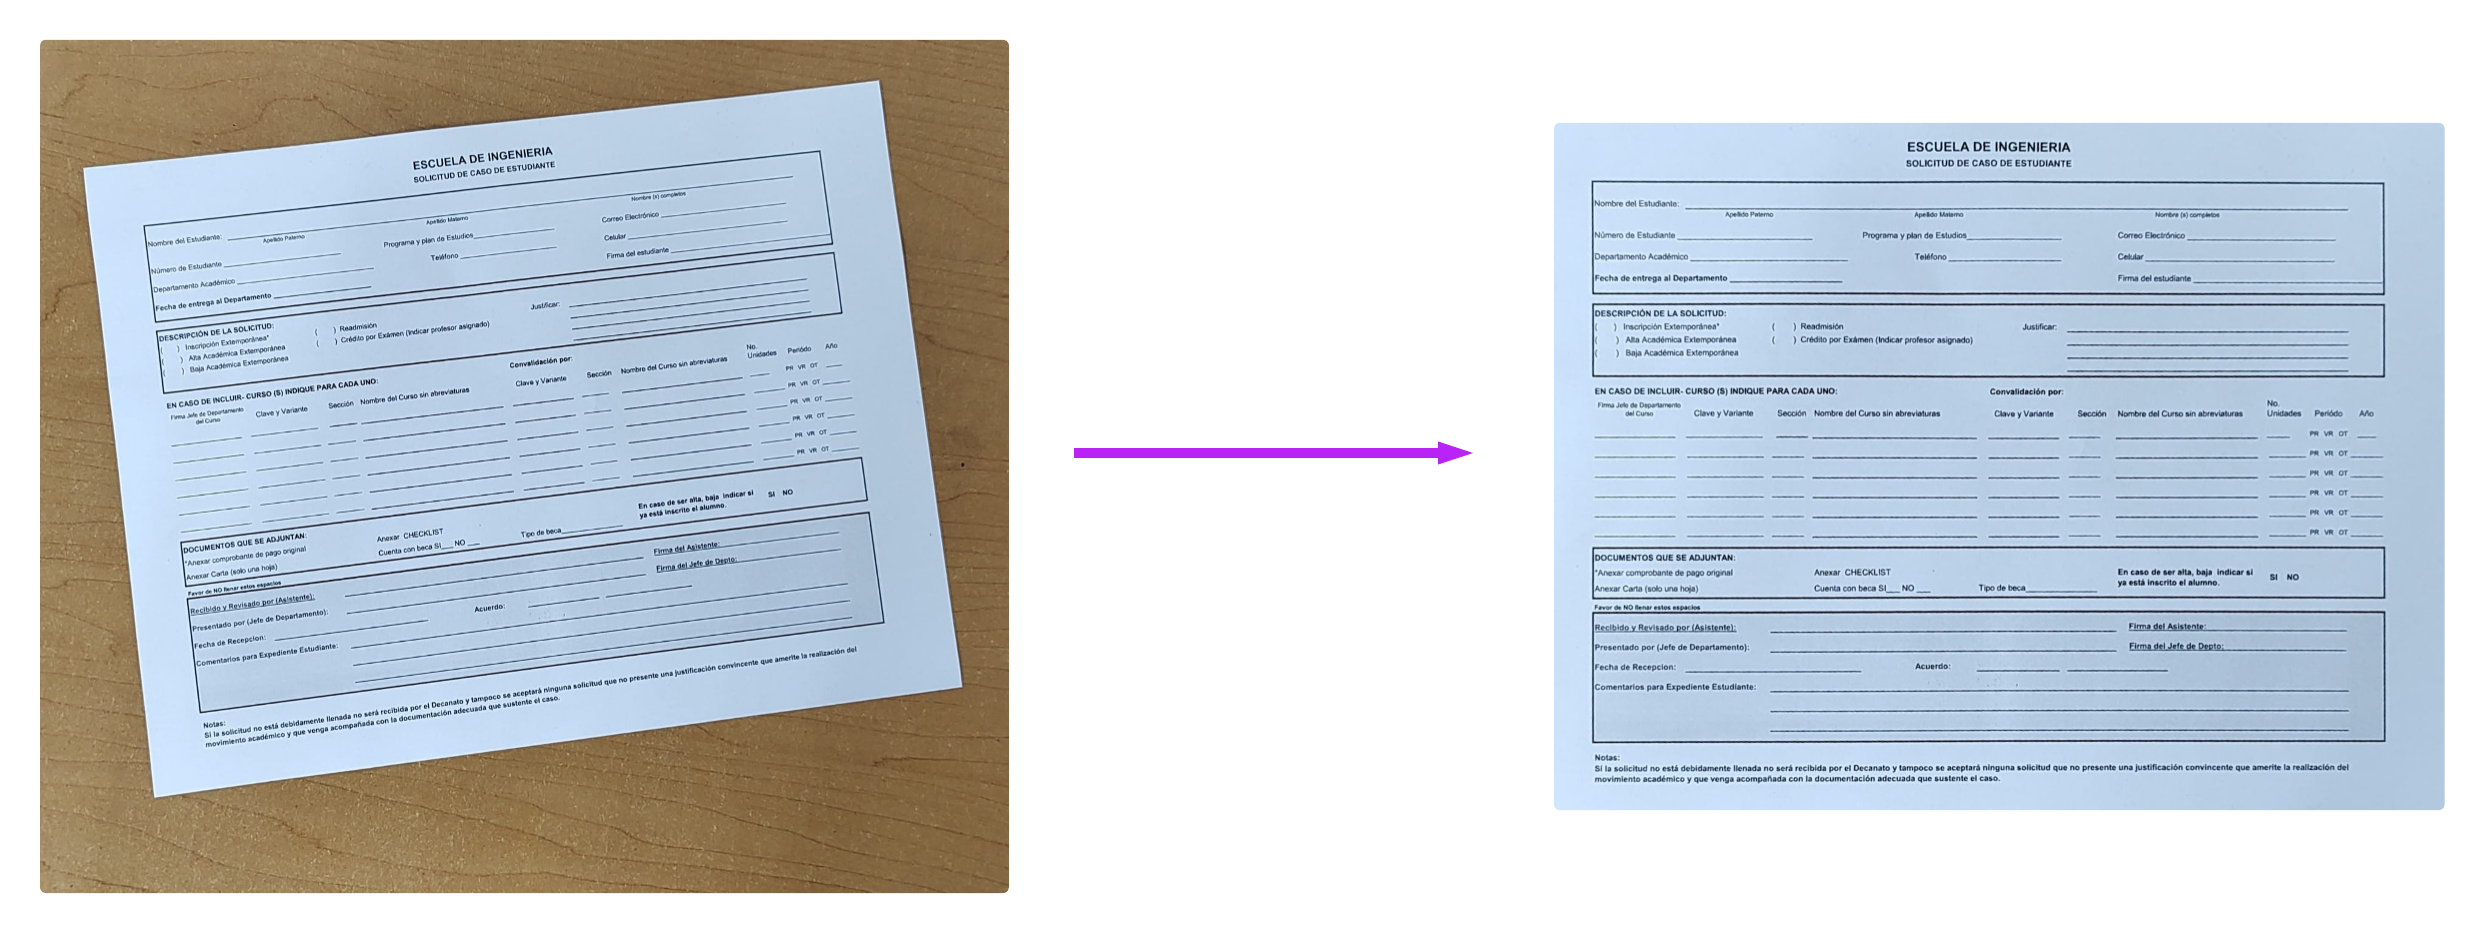

## Theory

1. A **Homography** transforms a square to arbitrary quad. 

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography

<div style="display: flex; justify-content: space-between;">
    <img src="datos/ImageFeaturesAndAlignment/macbook.png" alt="Macbook 1" style="width: 48%;"/>
    <img src="datos/ImageFeaturesAndAlignment/macbook2.png" alt="Macbook 2" style="width: 48%;"/>
</div>

## Read Template and Scanned Image

In [2]:
# Read reference image
refFilename = "datos/ImageFeaturesAndAlignment/original_form.png"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

Reading reference image: datos/ImageFeaturesAndAlignment/original_form.png


In [3]:
# Read image to be aligned
imFilename = "datos/ImageFeaturesAndAlignment/scanned_form.png"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Reading image to align: datos/ImageFeaturesAndAlignment/scanned_form.png


Text(0.5, 1.0, 'Scanned Form')

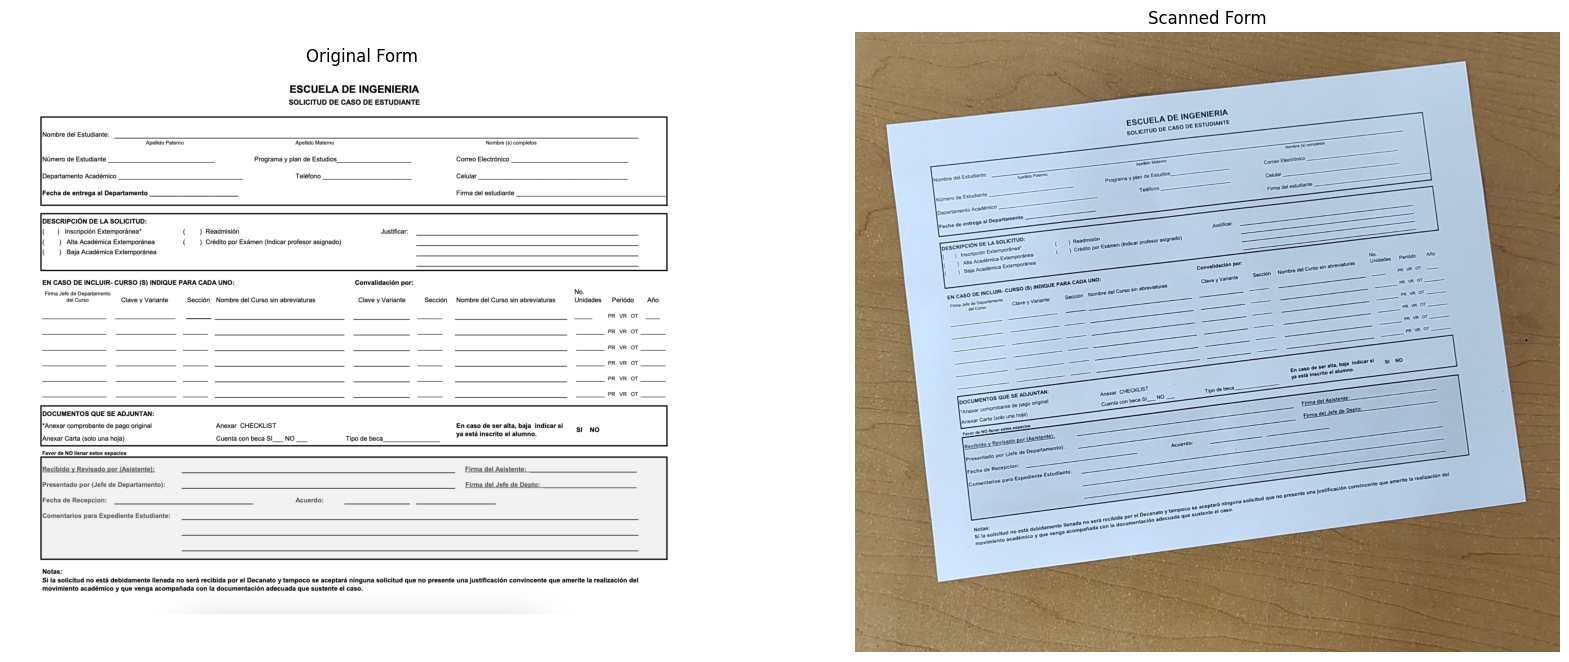

In [4]:
# Display Images
plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations.

The feature detection used for this is ORB (Oriented FAST and Rotated BRIEF) that is a fast and efficient feature detection and description algorithm in OpenCV. It combines the strengths of two algorithms:

1. FAST (Features from Accelerated Segment Test) :
    - Detects keypoints by identifying corners or interest points in an image.
    - Computationally efficient but lacks orientation information.
2. BRIEF (Binary Robust Independent Elementary Features) :
    - Generates a binary descriptor for each keypoint, which is compact and fast to compute.
    - Not rotation-invariant by itself.

In [5]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

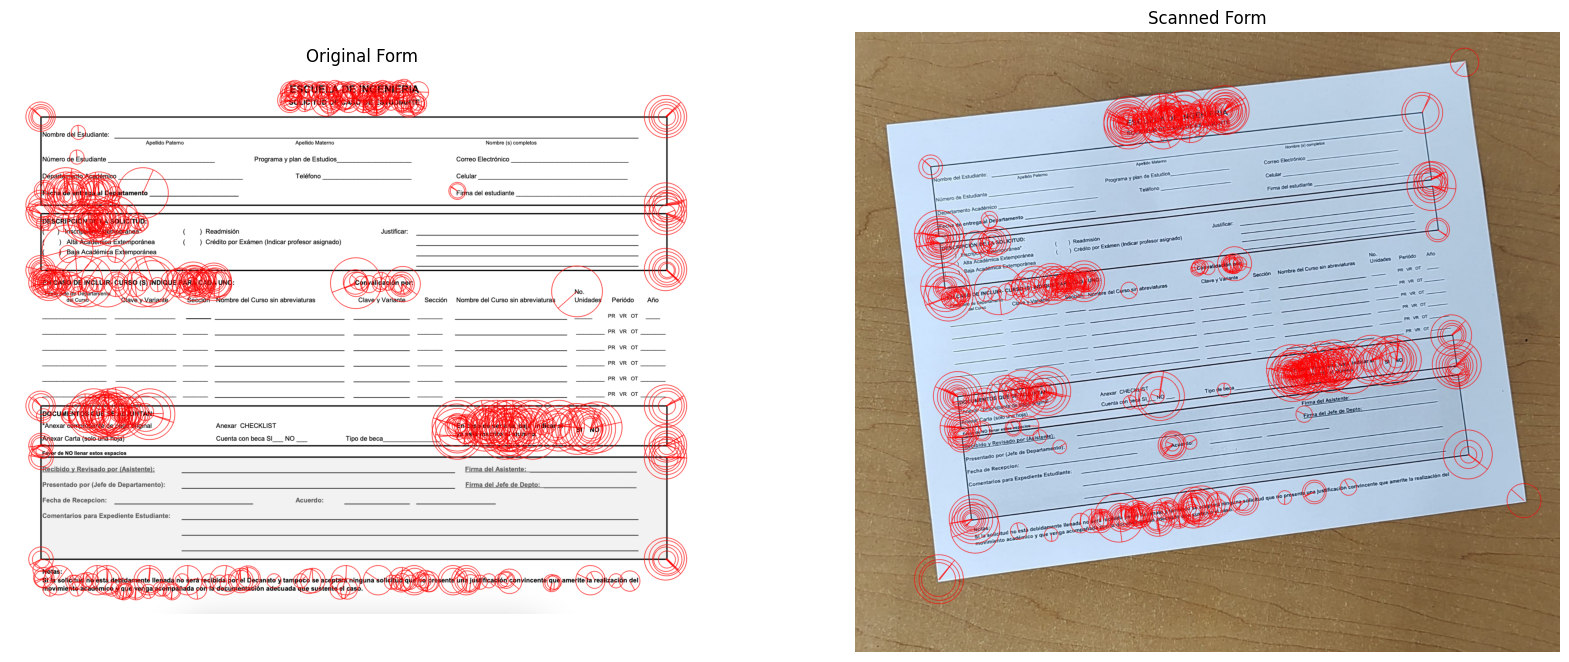

In [6]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## Match keypoints in both images

To match keypoints between the two images, we utilize the `cv2.DescriptorMatcher_create` method. This function is part of OpenCV's feature-matching framework and is designed to compare descriptors extracted from the images, identifying corresponding keypoints based on their similarity.

**Function Syntax**:
   
```python
cv2.DescriptorMatcher_create(matcher_type)
```

`matcher_type` : A string specifying the type of matcher to use. Common options include:

- `BruteForce`: Exhaustively compares all descriptors (simple but computationally expensive).
- `FlannBased`: Uses the FLANN (Fast Library for Approximate Nearest Neighbors) algorithm for faster matching, especially suitable for large datasets.
- `BruteForce-L1`, "BruteForce-Hamming", etc.: Variants optimized for specific distance metrics.

In [7]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Convert matches to a list to enable sorting, as tuples are immutable and cannot be reordered.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

print("Structure of a match: ")
print(f"  queryIdx: {matches[0].queryIdx}")
print(f"  trainIdx: {matches[0].trainIdx}")
print(f"  distance: {matches[0].distance}")

Structure of a match: 
  queryIdx: 446
  trainIdx: 402
  distance: 18.0


## Draw the best matches

Text(0.5, 1.0, 'Original Form')

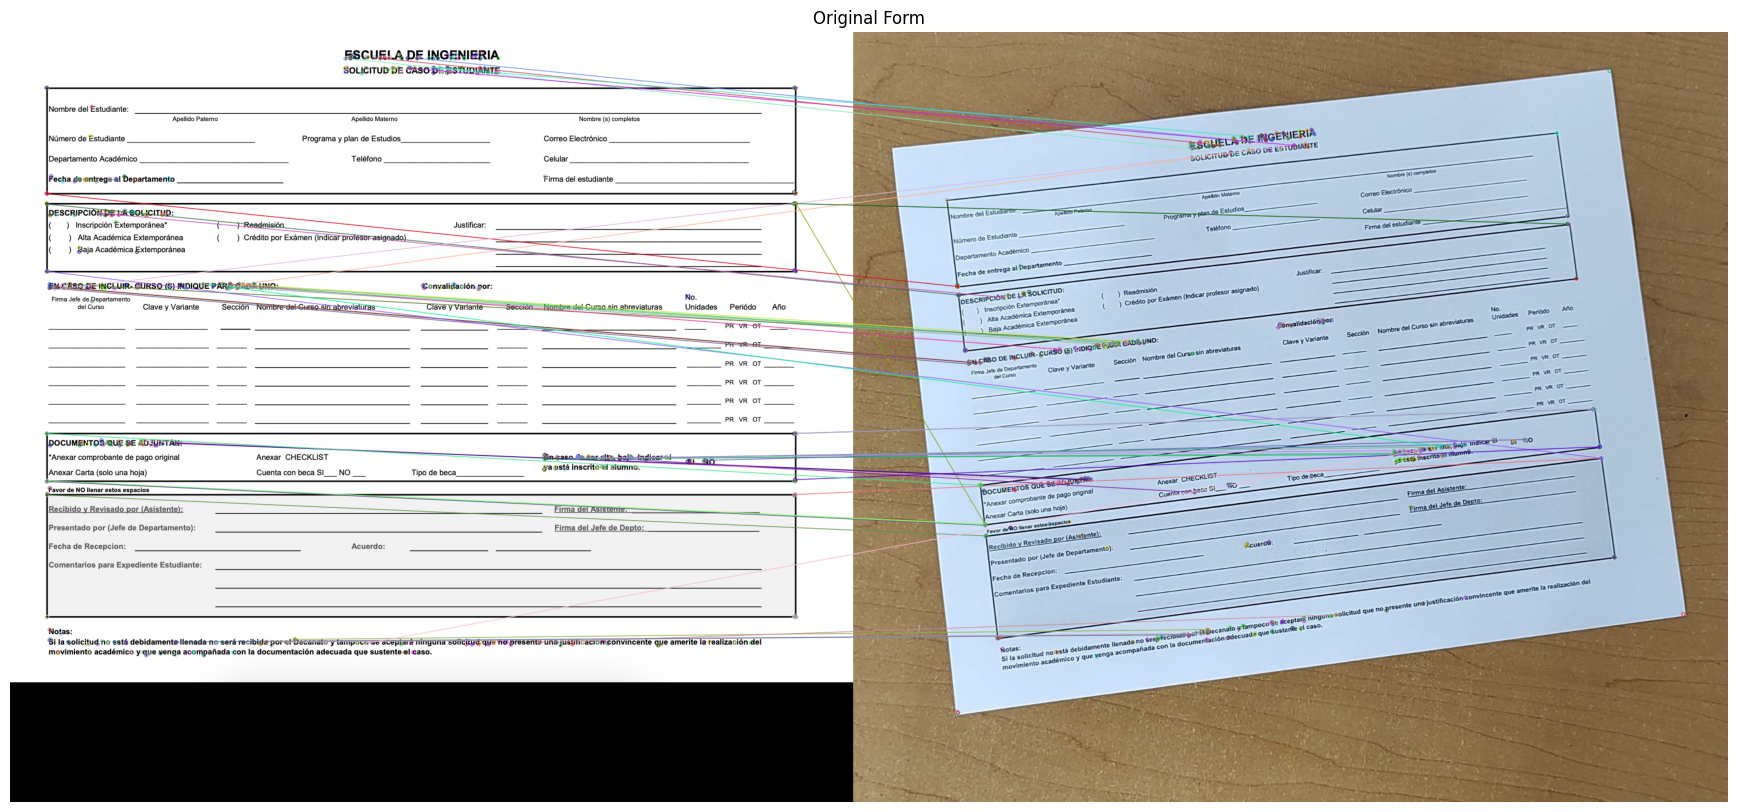

In [8]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

## Find Homography

The `cv2.findHomography` method in OpenCV is used to compute the homography matrix between two sets of corresponding points in two images. Homography is a mathematical transformation (a 3 x 3 matrix) that maps points from one plane in an image to another plane in a different image.

**Function Syntax**
``` python
retval, mask = cv2.findHomography(srcPoints, dstPoints, method=None, ransacReprojThreshold=None, mask=None, maxIters=None, confidence=None)
```

1. `srcPoints` :
- Type: numpy.ndarray or list of points.
- Description: Coordinates of points in the first image (source image). It can be an array of size Nx2 (where N is the number of points) or an array of size Nx1 with each element being a 2x1 matrix.
2. `dstPoints` :
- Type: numpy.ndarray or list of points.
- Description: Coordinates of corresponding points in the second image (destination image). It must have the same format as srcPoints.
3. `method` (optional):
- Type: Integer.
- Description: Method used to compute the homography.
Possible values are:
- `0`: Uses all points (without RANSAC or LMedS).
- `cv2.RANSAC`: Uses the RANSAC algorithm to eliminate outliers.
- `cv2.LMEDS`: Uses the Least-Median of Squares (LMedS) algorithm.

4. `ransacReprojThreshold` (optional):
- Type: Float.
- Description: Maximum allowed reprojection error threshold when using RANSAC. Points with an error greater than this threshold are considered outliers.

5. `mask` (optional):
- Type: Mask array.
- Description: Output mask indicating which points are inliers (included in the computation) and which are outliers.

6. `maxIters` (optional):
- Type: Integer.
- Description: Maximum number of iterations for the RANSAC algorithm.
confidence (optional):

- Type: Float.
- Description: Desired confidence level for the RANSAC result (e.g., 0.99 for 99%).

**Return Values**

7. `retval` :

- Type: numpy.ndarray.

- Description: The computed homography matrix. This matrix can be used with functions like cv2.warpPerspective to apply the transformation.

8. `mask` :

- Type: numpy.ndarray.

- Description: A mask indicating which points were considered inliers during the homography calculation.



In [9]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

# Fill arrays with keypoint coordinates
for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography with RANSAC method to eliminate outliers
homography, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

print("Homography matrix:")
print(homography)

Homography matrix:
[[ 1.18608141e+00 -1.34931985e-01 -9.54633641e+01]
 [ 1.34968477e-01  1.21452587e+00 -2.94264606e+02]
 [-1.85328766e-05  1.94995209e-05  1.00000000e+00]]


## Warp Image

The cv2.warpPerspective method in OpenCV is used to apply a perspective transformation (using a homography matrix) to an image. This method is typically used after computing a homography matrix with cv2.findHomography. It allows you to warp or transform an image according to the specified 3x3 transformation matrix, which can be used for tasks such as perspective correction, image stitching, or aligning images.

**Function Syntax**
``` python
dst = cv2.warpPerspective(src, M, dsize, flags=None, borderMode=None, borderValue=None)
```

1. `src` :
- Type: numpy.ndarray.
- Description: The source image that you want to transform. This is the input image.
2. `M` :
- Type: numpy.ndarray (3x3 matrix).
- Description: The 3x3 transformation matrix (homography matrix) that defines the perspective transformation. This matrix is typically obtained using cv2.findHomography.
3. `dsize` :
- Type: Tuple (width, height).
- Description: The size of the output image (width, height) after applying the transformation.
4. `flags` (optional):
- Type: Integer.
- Description: Interpolation method used for the transformation. Common values include:
- `cv2.INTER_LINEAR`: Bilinear interpolation (default).
- `cv2.INTER_NEAREST`: Nearest-neighbor interpolation.
- `cv2.INTER_CUBIC`: Bicubic interpolation.
- `cv2.INTER_LANCZOS4`: Lanczos interpolation over 8x8 neighborhood.
5. `borderMode` (optional):
- Type: Integer.
- Description: Pixel extrapolation method. Common values include:
- `cv2.BORDER_CONSTANT`: Adds a constant colored border.
- `cv2.BORDER_REPLICATE`: Replicates the edge pixels.
- `cv2.BORDER_REFLECT`: Reflects the pixels at the boundaries.
6. `borderValue` (optional):
- Type: Scalar (e.g., (B, G, R) tuple).
- Description: Value used for the border if borderMode is set to cv2.BORDER_CONSTANT. Default is 0 (black).

**Return Values**

1. `st` :
- Type: numpy.ndarray.
- Description: The transformed (warped) output image.

Text(0.5, 1.0, 'Scanned Form')

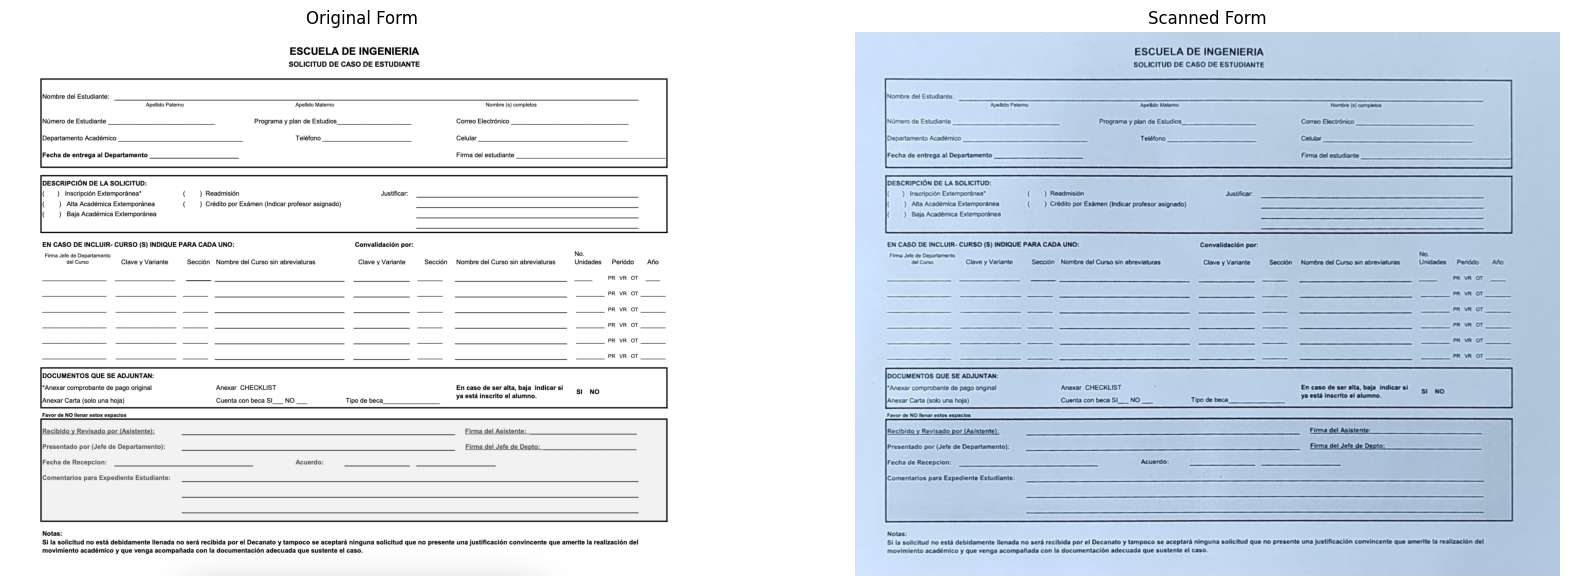

In [10]:
# Use homography to warp image
height, width, channels = im1.shape
size = (width, height)

# Warp image using homography
im2_reg = cv2.warpPerspective(im2, homography, size)

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")

## Saved Wrapped Image

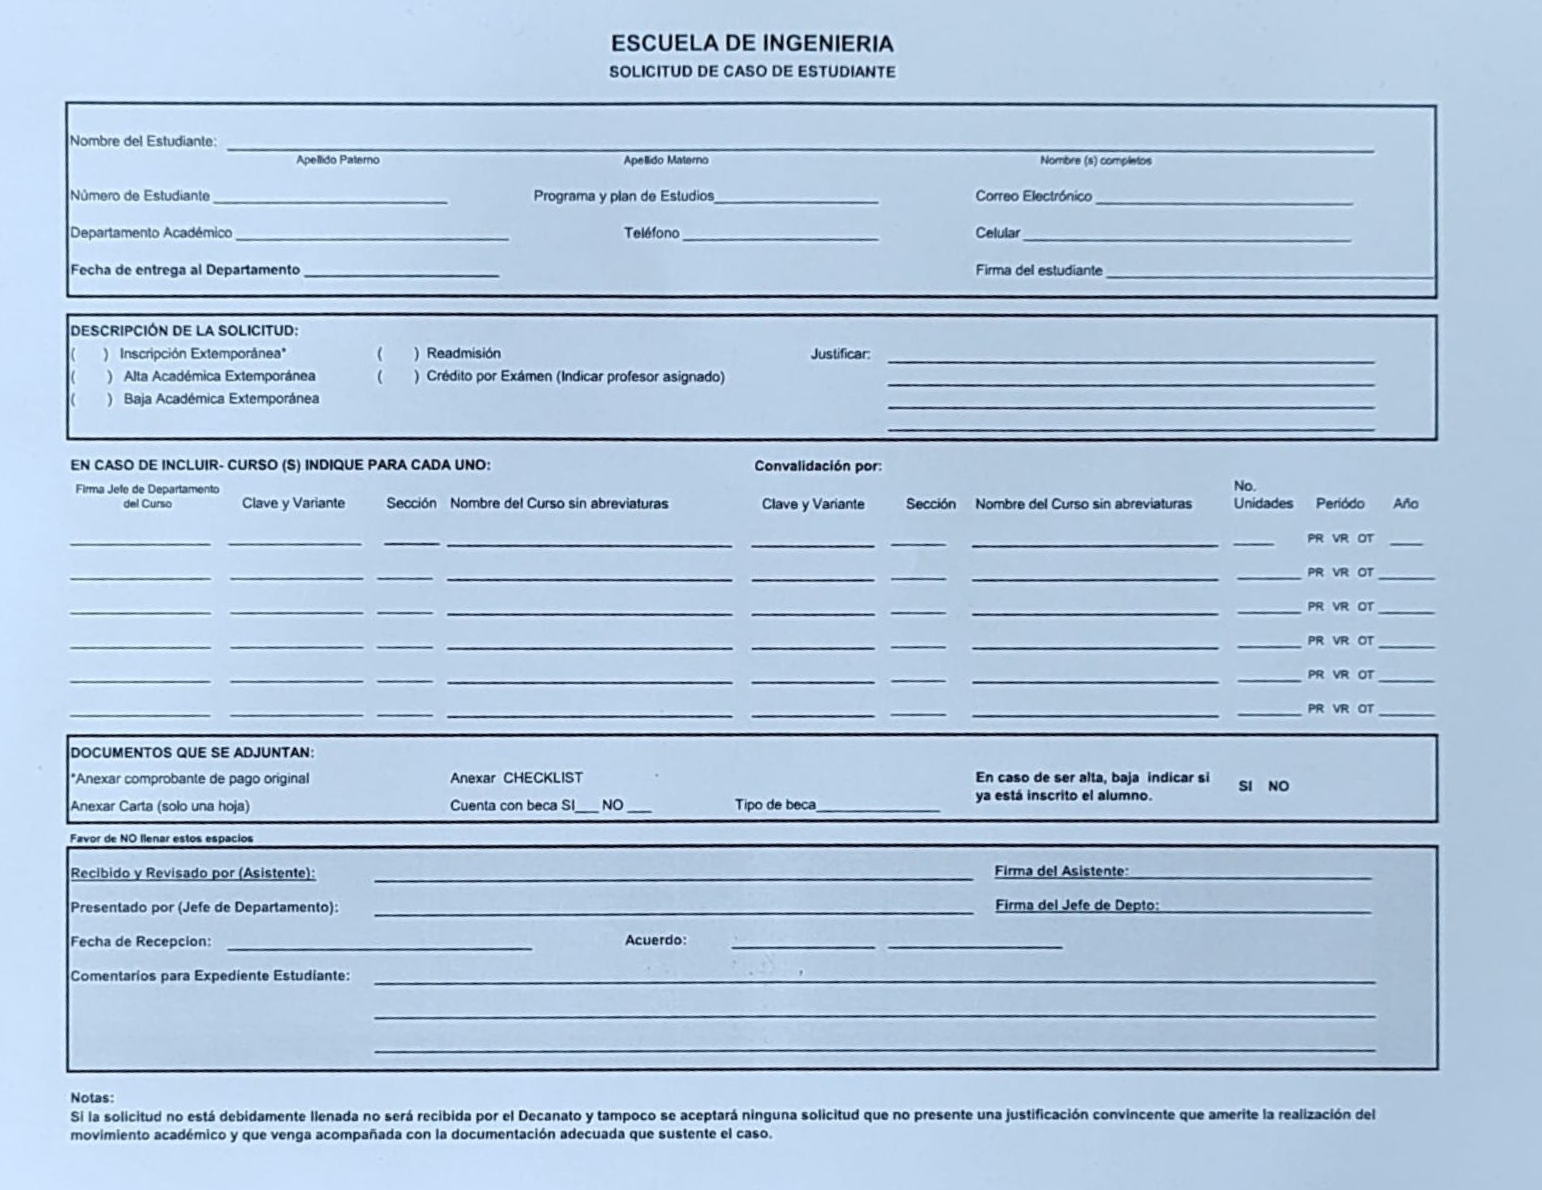

In [11]:
# Save result image
cv2.imwrite("datos/ImageFeaturesAndAlignment/Saved/wrapped_form.png", im2_reg[:, :, ::-1])
# Display the final image
Image(filename="datos/ImageFeaturesAndAlignment/Saved/wrapped_form.png")